# Example: Quantized Consensus

This notebook demonstrates a Laplacian-matrix-based consensus implementation **with a quantization-enabled communication transform**.
The goal is to show how exchanging **quantized state vectors** (e.g., int8 + scale metadata) can reduce communication cost while still achieving consensus.

This experiment runs multiple processes as computing nodes on a single machine.  
For deploying nodes across multiple machines (e.g., Raspberry Pi over TCP), refer to
[examples/scripts/node.py](../scripts/node.py) for a runnable template and integration details.

## 1. Global parameters

In [4]:
if __name__ == "__main__":
    N_STATE = 3
    N_NODES = 5

## 2. Deploy the nodes using multiprocessing:
Here, we use the consensus iteration formula:
$$
x(k+1) = x(k) - \alpha L x(k),
$$
where $L$ is the Laplacian matrix of the graph.

In [5]:
from multiprocessing import Pool
from numpy import float64
from numpy.typing import NDArray


def graph_server() -> None:
    from logging import basicConfig, INFO

    basicConfig(level=INFO)

    from topolink import Graph

    nodes = ["1", "2", "3", "4", "5"]
    edges = [("1", "2"), ("2", "3"), ("3", "4"), ("4", "5"), ("5", "1")]

    graph = Graph(nodes, edges)

    graph.deploy()


def laplacian_consensus(idx: str, n_state: int, n_iter: int = 50) -> NDArray[float64]:
    from numpy import zeros
    from numpy.random import uniform, seed
    from topolink import NodeHandle, Quantize

    nh = NodeHandle(idx, transform=Quantize(scale=10.0))

    states = zeros((n_iter, n_state))
    seed(int(idx))  # Ensure reproducibility for each node
    states[0] = uniform(-100.0, 100.0, n_state)

    for k in range(n_iter - 1):
        lap_state = nh.laplacian(states[k])
        states[k + 1] = states[k] - lap_state * 0.45

    return states


if __name__ == "__main__":
    with Pool(N_NODES + 1) as pool:
        server = pool.apply_async(graph_server)
        tasks = [
            pool.apply_async(laplacian_consensus, args=(str(i + 1), N_STATE))
            for i in range(N_NODES)
        ]
        node_states = [task.get() for task in tasks]
        server.get()

INFO:topolink.graph:Graph 'default' running on: 10.20.13.39:46615
INFO:topolink.discovery:Registered graph service with name 'default'
INFO:topolink.graph:Node '3' joined graph 'default' from 10.20.13.39:45111.
INFO:topolink.graph:Node '4' joined graph 'default' from 10.20.13.39:46415.
INFO:topolink.graph:Node '5' joined graph 'default' from 10.20.13.39:45697.
INFO:topolink.graph:Node '1' joined graph 'default' from 10.20.13.39:45285.
INFO:topolink.graph:Node '2' joined graph 'default' from 10.20.13.39:45949.
INFO:topolink.graph:Graph 'default' registration complete.
INFO:topolink.graph:Sent neighbor information to all nodes in graph 'default'.
INFO:topolink.discovery:Unregistered graph service with name 'default'


**Note:**
The order in which the nodes and server are started does not affect the overall program.

## 3. Plot the results:

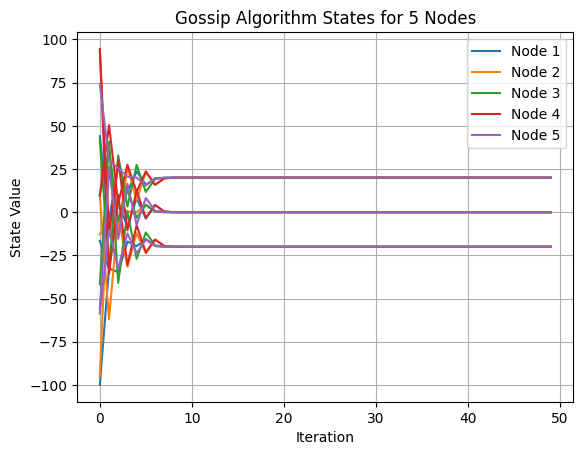

In [6]:
if __name__ == "__main__":
    import matplotlib.pyplot as plt

    _, ax = plt.subplots()

    colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]

    for i in range(N_NODES):
        states = node_states[i]
        for j in range(N_STATE):
            (line,) = ax.plot(states[:, j], color=colors[i])
            line.set_label(f"Node {i + 1}") if j == 0 else None

    ax.set_xlabel("Iteration")
    ax.set_ylabel("State Value")
    ax.grid()
    ax.legend()
    ax.set_title(f"Gossip Algorithm States for {N_NODES} Nodes")

    plt.show()